### 画像をn枚のパッチに分割しノード特徴を対応する画像パッチとする。画像はカラー画像とする。エッジは最近傍ノードにエッジを張る
一応エッジにはパッチ間のコサイン類似度を代入する。

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random
import cv2
from tqdm import tqdm
import dgl
import networkx as nx
from torchvision.datasets import STL10
from torchvision import transforms
import torchvision.transforms.functional as F

target_size=(224,224)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(target_size)
])

STL10_train = STL10("STL10", split='train', download=True, transform=transform)
 
STL10_test = STL10("STL10", split='test', download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
def get_nearest_neighbors(image, row, col): #最近傍ノード番号の取得
    # 画像の形状を取得
    height, width = image.shape[:2]

    # 注目画素の周囲8画素の座標を計算
    neighbors_coords = [(row-1, col-1), (row-1, col), (row-1, col+1),
                        (row, col-1), (row, col+1),
                        (row+1, col-1), (row+1, col), (row+1, col+1)]

    # 注目画素の最近傍画素の値を抜き出す
    nearest_neighbors = []
    for r, c in neighbors_coords:
        # 座標が画像範囲内かチェック
        if 0 <= r < height and 0 <= c < width:
            pixel_value = image[r, c]
            nearest_neighbors.append(pixel_value)
        else:
            # 画像範囲外の場合は0を追加するなど適切な処理を行う
            #nearest_neighbors.append(0)
            pass

    return nearest_neighbors
def make_graph(side_length): #パッチ数分のグラフを作成
    g=dgl.DGLGraph()
    g.add_nodes(side_length**2)
    square_list = np.arange(side_length**2).reshape((side_length, side_length))
    #ノード番号に対応したインデックスを取得
    inds=np.ndindex(square_list.shape)
    inds=[idx for idx in inds]
    #各ノードと最近傍ノード間にエッジを張る
    for i in range(side_length**2):
        x,y=inds[i]
        flatt_nh=get_nearest_neighbors(square_list,x,y)
        for j in flatt_nh:
            if i == j:
                continue
            else:
                g.add_edges(j,i)
    return g
def image_patch(image,num_patch):
    #画像サイズ
    size=image.shape[1]
    #1パッチ当たりの画素数
    patch_width=int(size/num_patch)
    #パッチ保存用配列
    data=[]

    for i in range(0,size,patch_width):
        for j in range(0,size,patch_width):
            data.append(image[:, i : i + patch_width, j : j + patch_width])
    
    return torch.stack(data,dim=0)

In [14]:
#パッチ数
num_patch=8

#トレーニングデータセット
graphs=[]
labels=[]
test_mode=False
complete_graph=True
test_mumber=100

for image,label in tqdm(STL10_train):
    if test_mode == True:
        if test_mumber < 0:
            break
        else:
            test_mumber -= 1
    #画像をパッチに分割
    n_feat=image_patch(image,num_patch)
    #グラフ作成
    if complete_graph:
        g=nx.complete_graph(num_patch**2)
        G=dgl.from_networkx(g)
        G.ndata['f']=n_feat
    else:
        G=make_graph(num_patch)
        #グラフにノード特徴 'f' としてパッチ画像を入力
        G.ndata['f']=n_feat

    #graphsにグラフ labelsにラベルを代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/train/ndata_8patch_comp.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)



100%|██████████| 5000/5000 [01:28<00:00, 56.43it/s]


In [13]:

#テストデータセット
graphs=[]
labels=[]
test_mode=False
complete_graph=True
test_mumber=100

for image,label in tqdm(STL10_test):
    if test_mode == True:
        if test_mumber < 0:
            break
        else:
            test_mumber -= 1
    #画像をパッチに分割
    n_feat=image_patch(image,num_patch)
    #グラフ作成
    if complete_graph:
        g=nx.complete_graph(num_patch**2)
        G=dgl.from_networkx(g)
        G.ndata['f']=n_feat
    else:
        G=make_graph(num_patch)
        #グラフにノード特徴 'f' としてパッチ画像を入力
        G.ndata['f']=n_feat

    #graphsにグラフ labelsにラベルを代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/test/ndata_8patch_comp.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)

print('end')

100%|██████████| 8000/8000 [02:22<00:00, 56.30it/s]


end


c:\Users\kisim\anaconda3\envs\GNN_DGL2\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


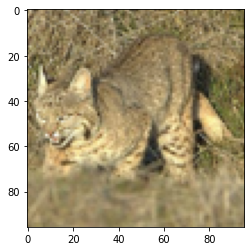

224
28


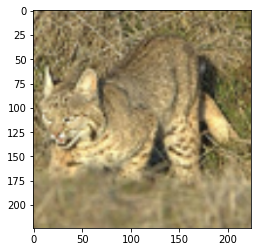

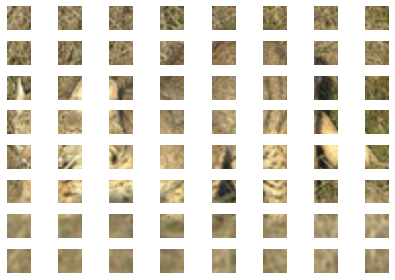

patch num: 8  patch pic size: 28  class: 3


In [4]:
#画像一枚読み込み
image,label=STL10_train[4]
#オリジナル画像作成
orig=F.resize(image,(96,96))
#HWCに入れ替え
image=image.permute(1,2,0)
orig=orig.permute(1,2,0)
#表示
plt.imshow(orig)
plt.show()
plt.imshow(image)
#パッチに分割
#画像をn分割。
num_patch=8
size=image.shape[0]
print(size)
patch_width=int(size/num_patch)
print(patch_width)
data=[]

for i in range(0,size,patch_width):
    #print(i)
    for j in range(0,size,patch_width):
        #print(j)
        data.append(image[i: i + patch_width,j: j + patch_width, :])

#分割した各パッチを正方形に表示
# 1枚の図を作成
fig = plt.figure()

# 画像を追加
for i in range(num_patch**2):
    ax = fig.add_subplot(num_patch, num_patch, i+1)
    ax.imshow(data[i])
    ax.axis('off')

# 画像を表示
plt.tight_layout()
plt.show()
print(f'patch num: {num_patch}  patch pic size: {patch_width}  class: {label}')